In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [4]:
df = pd.read_csv('iFlowDatos_Limpios.csv')

In [5]:
df.head(3)

,iddomicilioorden,direccion,provincia,municipio,localidad,InicioHorario1,FinHorario1,latitud,longitud,cliente,...,Bultos,Peso,Unidades,VisitaPlanificadaFecha,VisitaPlanificadaDia,VisitaPlanificadaHora,VisitaFecha,VisitaDia,VisitaHora_Inicio,VisitaHora_Fin
0,74956,VIDAL 2044,Ciudad Autónoma de Buenos Aires,Comuna 13,Belgrano,901,1401,-34.564779,-58.459956,70,...,2.516667,24.910,30,2024-05-23,Thursday,12:06:00,2024-05-23,Thursday,14:13:53,14:14:53
1,74956,VIDAL 2044,Ciudad Autónoma de Buenos Aires,Comuna 13,Belgrano,901,1401,-34.564779,-58.459956,70,...,2.866667,26.260,38,2024-05-10,Friday,12:05:00,2024-05-10,Friday,16:43:00,16:43:00
2,74956,VIDAL 2044,Ciudad Autónoma de Buenos Aires,Comuna 13,Belgrano,901,1401,-34.564779,-58.459956,70,...,2.400000,24.888,32,2024-05-30,Thursday,12:03:00,2024-05-30,Thursday,09:41:36,09:50:08


In [6]:
df2 = df.copy()

In [7]:
df2['VisitaHora_Inicio'] = pd.to_datetime(df2['VisitaHora_Inicio'], format='%H:%M:%S', errors='coerce')
df2['VisitaPlanificadaHora'] = pd.to_datetime(df2['VisitaPlanificadaHora'], format='%H:%M:%S')

# Restar los objetos de tiempo y convertir a minutos
df_time = pd.DataFrame({
    'VisitaHora_Inicio': df2['VisitaHora_Inicio'],
    'VisitaPlanificadaHora': df2['VisitaPlanificadaHora'],
    'Diferencia': (df2['VisitaPlanificadaHora'] - df2['VisitaHora_Inicio']).dt.total_seconds() / 60  # Convertir a minutos
})

# Redondear al número entero más cercano
df_time['Diferencia'] = df_time['Diferencia'].round()

# Remover las columnas 'VisitaHora_Inicio' y 'VisitaPlanificadaHora'
df_time = df_time.drop(['VisitaHora_Inicio', 'VisitaPlanificadaHora'], axis=1)

In [8]:
df_time.head()

,Diferencia
0,-128.0
1,-278.0
2,141.0
3,-79.0
4,-189.0


In [9]:
df_time['Anticipado'] = df_time['Diferencia'].apply(lambda x: x if x > 0 else 0)
df_time['Demora'] = df_time['Diferencia'].apply(lambda x: abs(x) if x < 0 else 0)

# Eliminar la columna Diferencia ya que se ha dividido en dos
df_time = df_time.drop(['Diferencia'], axis=1)

# Llenar los valores vacíos con 0
df_time.fillna(0, inplace=True)

In [10]:
df_time.head(2)

,Anticipado,Demora
0,0.0,128.0
1,0.0,278.0


In [11]:
# Asegurarse de que el índice coincida
df_time = df_time.set_index(df.index)

# Añadir las columnas de df_time al DataFrame original df
df = pd.concat([df, df_time], axis=1)

In [12]:
df.head()

,iddomicilioorden,direccion,provincia,municipio,localidad,InicioHorario1,FinHorario1,latitud,longitud,cliente,...,Unidades,VisitaPlanificadaFecha,VisitaPlanificadaDia,VisitaPlanificadaHora,VisitaFecha,VisitaDia,VisitaHora_Inicio,VisitaHora_Fin,Anticipado,Demora
0,74956,VIDAL 2044,Ciudad Autónoma de Buenos Aires,Comuna 13,Belgrano,901,1401,-34.564779,-58.459956,70,...,30,2024-05-23,Thursday,12:06:00,2024-05-23,Thursday,14:13:53,14:14:53,0.0,128.0
1,74956,VIDAL 2044,Ciudad Autónoma de Buenos Aires,Comuna 13,Belgrano,901,1401,-34.564779,-58.459956,70,...,38,2024-05-10,Friday,12:05:00,2024-05-10,Friday,16:43:00,16:43:00,0.0,278.0
2,74956,VIDAL 2044,Ciudad Autónoma de Buenos Aires,Comuna 13,Belgrano,901,1401,-34.564779,-58.459956,70,...,32,2024-05-30,Thursday,12:03:00,2024-05-30,Thursday,09:41:36,09:50:08,141.0,0.0
3,74956,VIDAL 2044,Ciudad Autónoma de Buenos Aires,Comuna 13,Belgrano,901,1401,-34.564779,-58.459956,70,...,28,2024-06-13,Thursday,12:14:00,2024-06-13,Thursday,13:32:55,13:39:55,0.0,79.0
4,74956,VIDAL 2044,Ciudad Autónoma de Buenos Aires,Comuna 13,Belgrano,901,1401,-34.564779,-58.459956,70,...,31,2024-06-27,Thursday,12:27:00,2024-06-27,Thursday,15:36:00,15:36:00,0.0,189.0


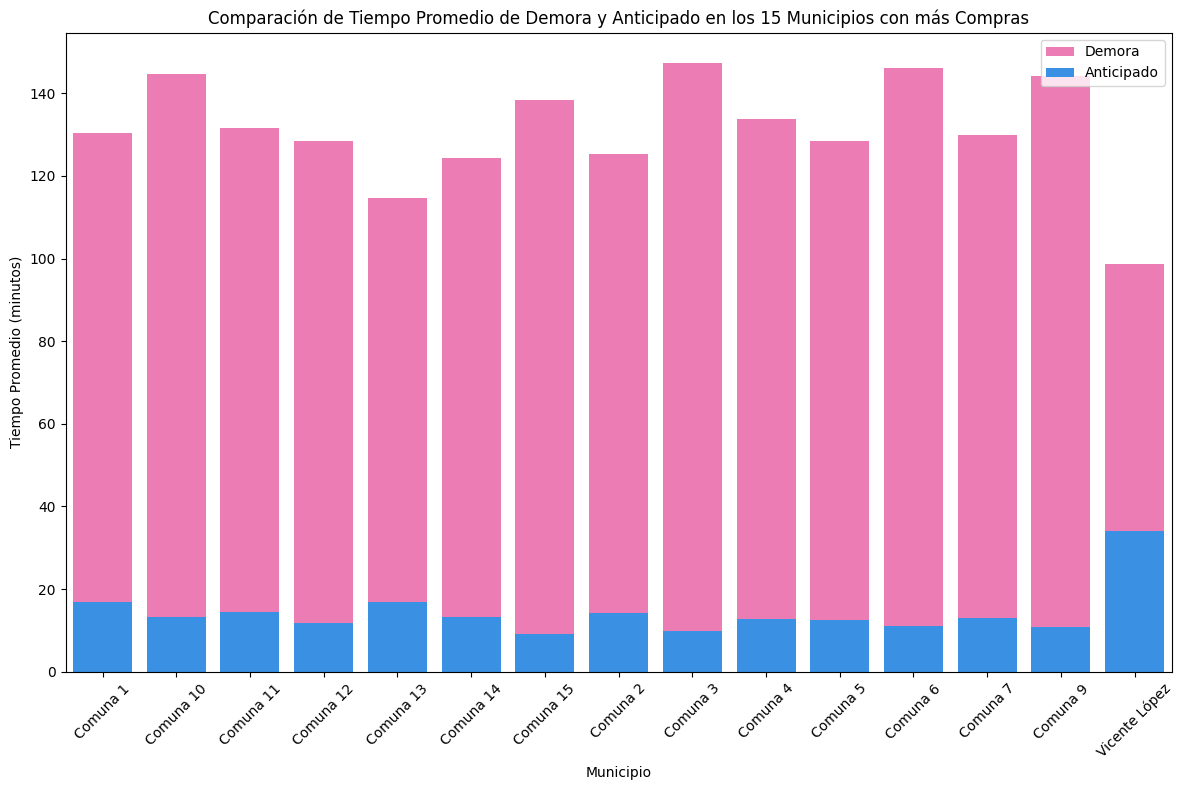

In [24]:
# Contar la cantidad de registros (compras) por municipio
compras_por_municipio = df.groupby('municipio').size().reset_index(name='total_compras')

# Seleccionar los 15 municipios con más compras
top_15_municipios = compras_por_municipio.nlargest(15, 'total_compras')['municipio']

# Filtrar el DataFrame original para solo incluir los municipios seleccionados
df_top_15 = df[df['municipio'].isin(top_15_municipios)]

# Agrupar por municipio y calcular el promedio de Demora y Anticipado en cada uno, excluyendo ceros si es necesario
df_grouped = df_top_15.groupby('municipio')[['Demora', 'Anticipado']].mean().reset_index()

# Crear el gráfico de barras
plt.figure(figsize=(12, 8))

# Crear un gráfico de barras para Demora
sns.barplot(x='municipio', y='Demora', data=df_grouped, color='#FF69B4', label='Demora')  # Color rosa

# Superponer el gráfico de barras para Anticipado
sns.barplot(x='municipio', y='Anticipado', data=df_grouped, color='#1E90FF', label='Anticipado')  # Color azul

# Añadir etiquetas y título
plt.xlabel('Municipio')
plt.ylabel('Tiempo Promedio (minutos)')
plt.title('Comparación de Tiempo Promedio de Demora y Anticipado en los 15 Municipios con más Compras')
plt.legend()

# Rotar los nombres de los municipios para que se vean mejor
plt.xticks(rotation=45)

# Mejorar el espaciado del gráfico
plt.tight_layout()



C:\Users\joela\AppData\Local\Temp\ipykernel_30812\2506046993.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='municipio', y='Demora', data=df_filtrado, palette=palette)
C:\Users\joela\AppData\Local\Temp\ipykernel_30812\2506046993.py:11: UserWarning: 
The palette list has fewer values (10) than needed (30) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='municipio', y='Demora', data=df_filtrado, palette=palette)


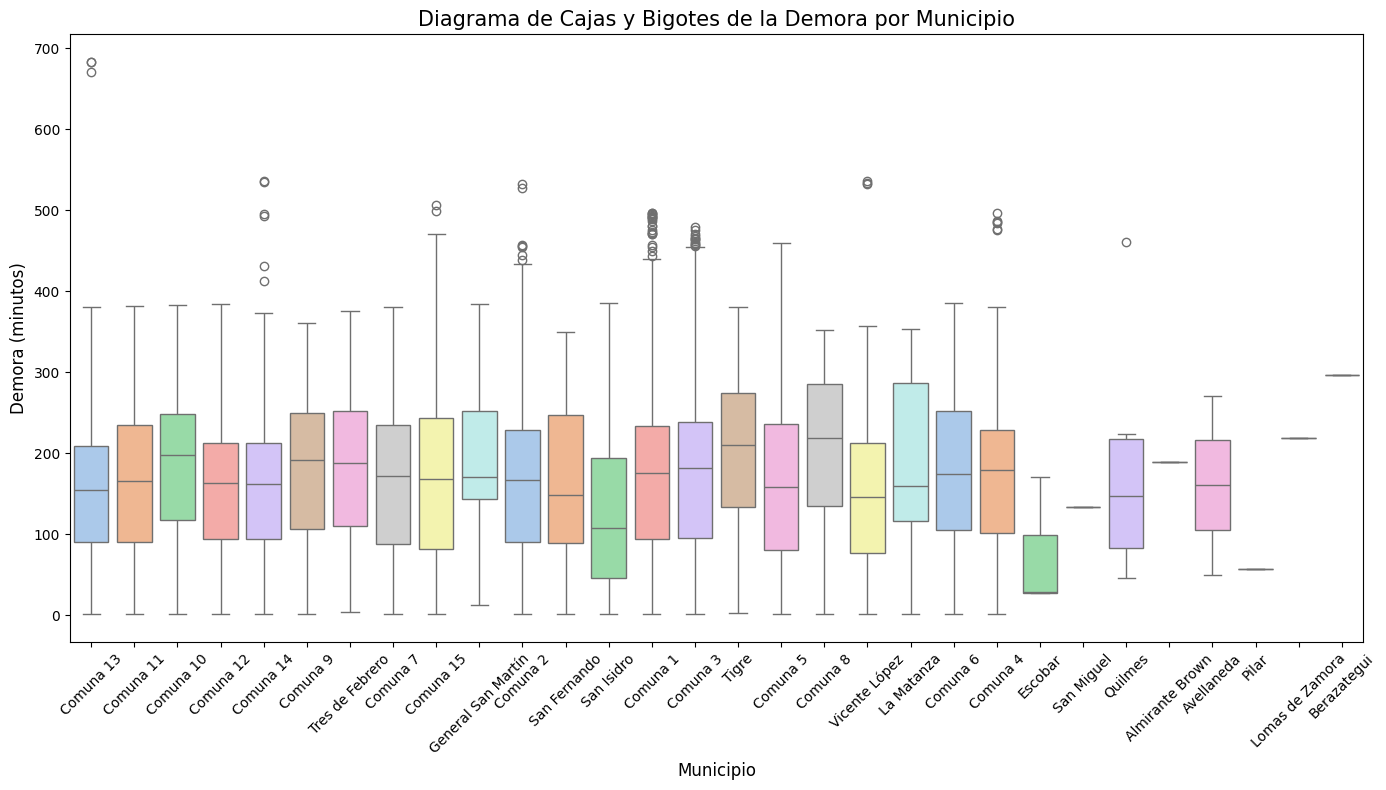

In [25]:
# Filtrar los datos para excluir las filas donde 'Demora' es igual a 0
df_filtrado = df[df['Demora'] != 0]

# Crear el diagrama de cajas y bigotes
plt.figure(figsize=(14, 8))

# Usar un color palette atractivo
palette = sns.color_palette("pastel")

# Crear el boxplot
sns.boxplot(x='municipio', y='Demora', data=df_filtrado, palette=palette)

# Añadir etiquetas y título
plt.xlabel('Municipio', fontsize=12)
plt.ylabel('Demora (minutos)', fontsize=12)
plt.title('Diagrama de Cajas y Bigotes de la Demora por Municipio', fontsize=15)

# Rotar los nombres de los municipios para que se vean mejor
plt.xticks(rotation=45)

# Mejorar el espaciado del gráfico
plt.tight_layout()


C:\Users\joela\AppData\Local\Temp\ipykernel_30812\2301163672.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='municipio', y='Demora', data=df_top_15_promedio, palette='viridis')


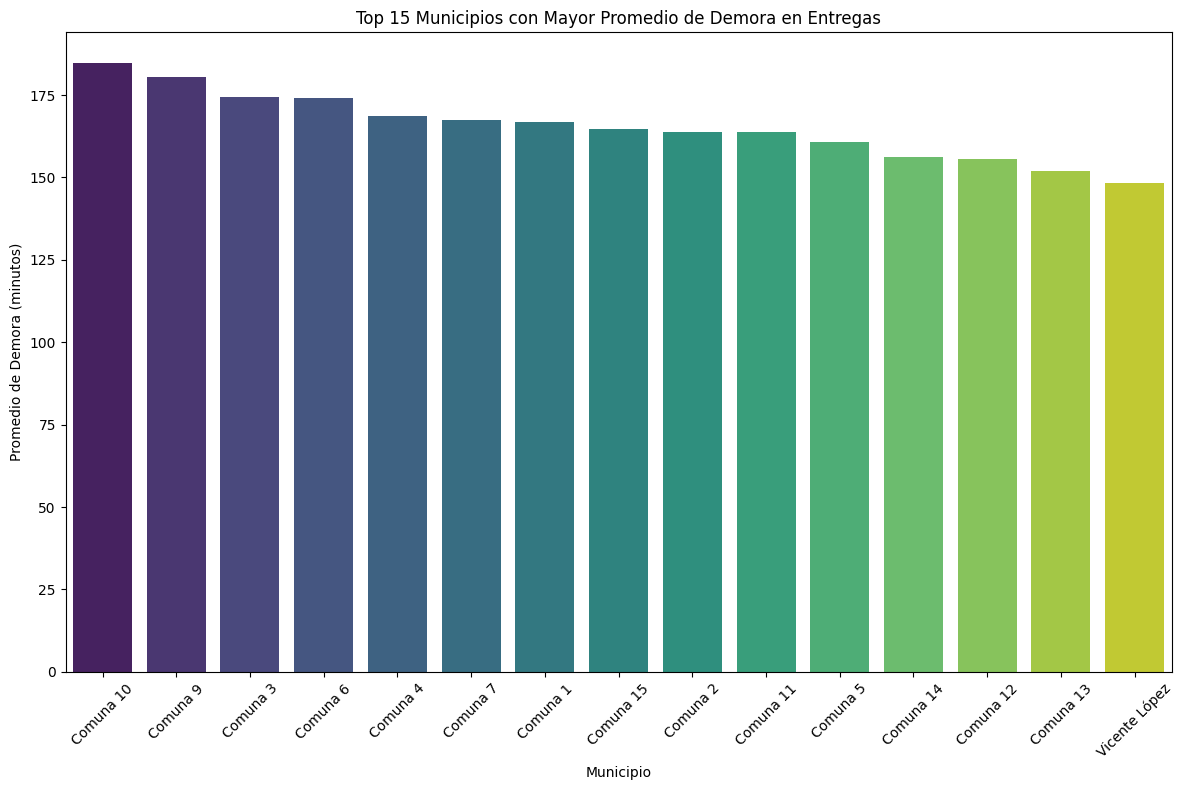

In [26]:
# Filtrar los datos para excluir las filas donde 'Demora' es igual a 0
df_filtrado = df[df['Demora'] != 0]

# Calcular el promedio de demora por municipio, excluyendo ceros
df_promedio_demora = df_filtrado.groupby('municipio')['Demora'].mean().reset_index()

# Seleccionar el top 15 de municipios con más compras
top_15_municipios = df.groupby('municipio').size().nlargest(15).index
df_top_15_promedio = df_promedio_demora[df_promedio_demora['municipio'].isin(top_15_municipios)]

# Ordenar de manera descendente por promedio de demora
df_top_15_promedio = df_top_15_promedio.sort_values(by='Demora', ascending=False)

# Crear el gráfico de barras vertical
plt.figure(figsize=(12, 8))
sns.barplot(x='municipio', y='Demora', data=df_top_15_promedio, palette='viridis')

# Añadir etiquetas y título
plt.xlabel('Municipio')
plt.ylabel('Promedio de Demora (minutos)')
plt.title('Top 15 Municipios con Mayor Promedio de Demora en Entregas')
plt.xticks(rotation=45)
plt.tight_layout()  # Mejora el espaciado para evitar solapamientos

C:\Users\joela\AppData\Local\Temp\ipykernel_30812\1002135354.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='municipio', y='Anticipado', data=df_top_15_anticipado, palette='viridis')


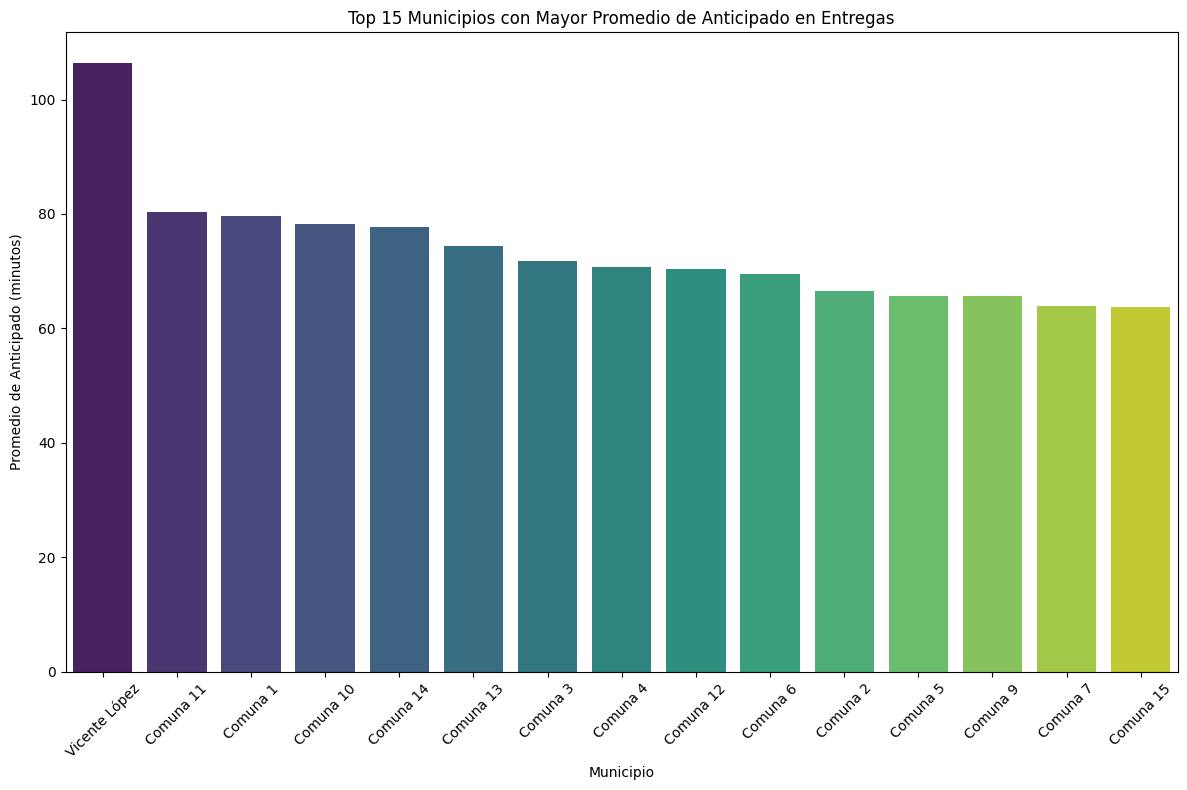

In [27]:
# Filtrar los datos para excluir las filas donde 'Anticipado' es igual a 0
df_filtrado = df[df['Anticipado'] != 0]

# Calcular el promedio de anticipado por municipio, excluyendo ceros
df_promedio_anticipado = df_filtrado.groupby('municipio')['Anticipado'].mean().reset_index()

# Seleccionar el top 15 de municipios con más compras
top_15_municipios = df.groupby('municipio').size().nlargest(15).index
df_top_15_anticipado = df_promedio_anticipado[df_promedio_anticipado['municipio'].isin(top_15_municipios)]

# Ordenar de manera descendente por promedio de anticipado
df_top_15_anticipado = df_top_15_anticipado.sort_values(by='Anticipado', ascending=False)

# Crear el gráfico de barras vertical
plt.figure(figsize=(12, 8))
sns.barplot(x='municipio', y='Anticipado', data=df_top_15_anticipado, palette='viridis')

# Añadir etiquetas y título
plt.xlabel('Municipio')
plt.ylabel('Promedio de Anticipado (minutos)')
plt.title('Top 15 Municipios con Mayor Promedio de Anticipado en Entregas')
plt.xticks(rotation=45)
plt.tight_layout()  # Mejora el espaciado para evitar solapamientos

C:\Users\joela\AppData\Local\Temp\ipykernel_30812\140643557.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_promedio_demora_dia = df_filtrado.groupby('VisitaDia')['Demora'].mean().reset_index()
C:\Users\joela\AppData\Local\Temp\ipykernel_30812\140643557.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VisitaDia', y='Demora', data=df_promedio_demora_dia, palette='viridis')


Text(0.5, 1.0, 'Demora Promedio por Día de la Semana (excluyendo ceros)')

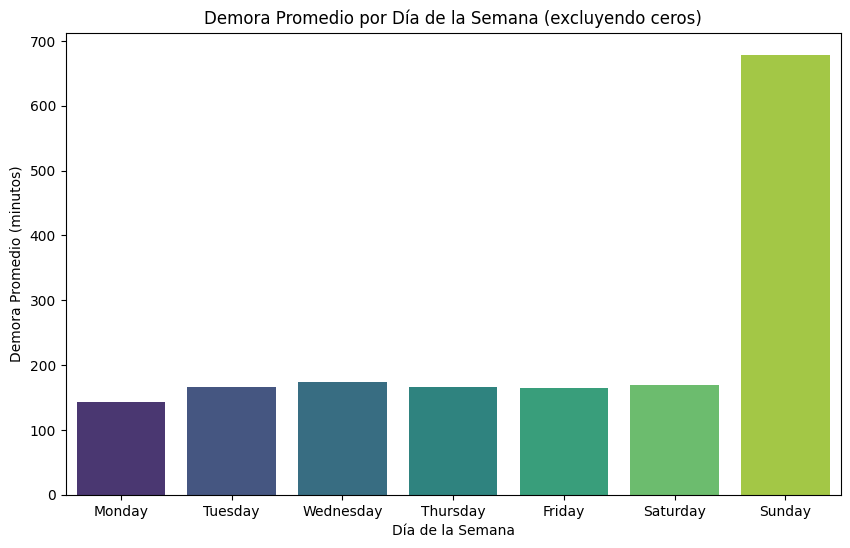

In [28]:

# Convertir la columna 'VisitaDia' a una categoría ordenada
dias_semana_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['VisitaDia'] = pd.Categorical(df['VisitaDia'], categories=dias_semana_orden, ordered=True)

# Filtrar los datos para excluir las filas donde 'Demora' es igual a 0
df_filtrado = df[df['Demora'] != 0]

# Calcular el promedio de demora por día de la semana, excluyendo ceros
df_promedio_demora_dia = df_filtrado.groupby('VisitaDia')['Demora'].mean().reset_index()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))

# Crear el gráfico de barras con una paleta más atractiva
sns.barplot(x='VisitaDia', y='Demora', data=df_promedio_demora_dia, palette='viridis')

# Añadir etiquetas y título
plt.xlabel('Día de la Semana')
plt.ylabel('Demora Promedio (minutos)')
plt.title('Demora Promedio por Día de la Semana (excluyendo ceros)')

C:\Users\joela\AppData\Local\Temp\ipykernel_30812\721627803.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_promedio_anticipado_dia = df_filtrado.groupby('VisitaDia')['Anticipado'].mean().reset_index()
C:\Users\joela\AppData\Local\Temp\ipykernel_30812\721627803.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VisitaDia', y='Anticipado', data=df_promedio_anticipado_dia, palette='magma')


Text(0.5, 1.0, 'Anticipado Promedio por Día de la Semana (excluyendo ceros)')

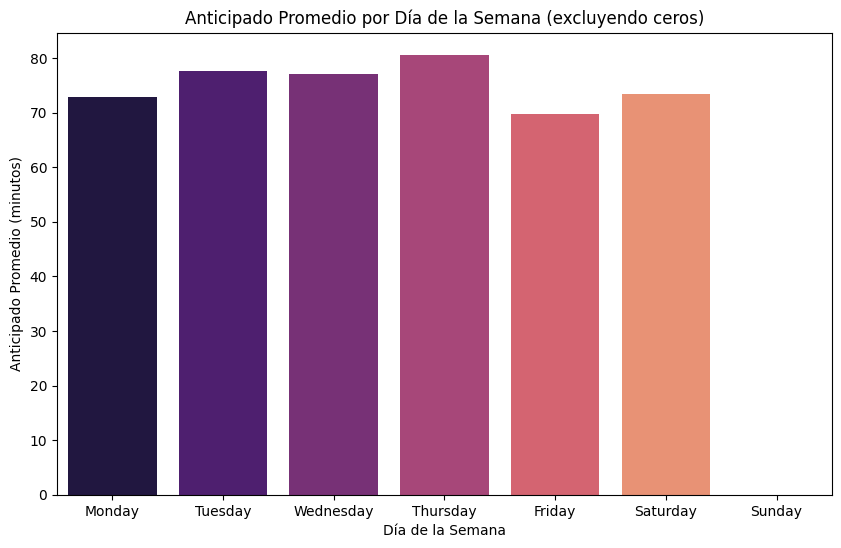

In [29]:
dias_semana_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['VisitaDia'] = pd.Categorical(df['VisitaDia'], categories=dias_semana_orden, ordered=True)

# Filtrar los datos para excluir las filas donde 'Anticipado' es igual a 0
df_filtrado = df[df['Anticipado'] != 0]

# Calcular el promedio de anticipado por día de la semana, excluyendo ceros
df_promedio_anticipado_dia = df_filtrado.groupby('VisitaDia')['Anticipado'].mean().reset_index()

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))

# Crear el gráfico de barras con la paleta 'magma'
sns.barplot(x='VisitaDia', y='Anticipado', data=df_promedio_anticipado_dia, palette='magma')

# Añadir etiquetas y título
plt.xlabel('Día de la Semana')
plt.ylabel('Anticipado Promedio (minutos)')
plt.title('Anticipado Promedio por Día de la Semana (excluyendo ceros)')

In [30]:
# Función para convertir a datetime y formatear a solo horas y minutos, manejando NaT
def convertir_hora(hora):
    hora_convertida = pd.to_datetime(hora, errors='coerce')  # Convierte a datetime, NaT si falla
    if pd.isna(hora_convertida):
        return None  # Si es NaT, devuelve None
    else:
        return hora_convertida.strftime('%H:%M')  # Formatea a solo horas y minutos

# Aplicar la conversión a las columnas
df['VisitaPlanificadaHora'] = df['VisitaPlanificadaHora'].apply(convertir_hora)
df['VisitaHora_Inicio'] = df['VisitaHora_Inicio'].apply(convertir_hora)

# Comparar las horas ignorando los segundos
iguales = (df['VisitaPlanificadaHora'] == df['VisitaHora_Inicio']).sum()

print(f'Número de registros con horas y minutos iguales: {iguales}')


Número de registros con horas y minutos iguales: 0


In [20]:
df.tail(5)

,iddomicilioorden,direccion,provincia,municipio,localidad,InicioHorario1,FinHorario1,latitud,longitud,cliente,...,Unidades,VisitaPlanificadaFecha,VisitaPlanificadaDia,VisitaPlanificadaHora,VisitaFecha,VisitaDia,VisitaHora_Inicio,VisitaHora_Fin,Anticipado,Demora
27479,183140,CASTILLO 767,Ciudad Autónoma de Buenos Aires,Comuna 15,Villa Crespo,901,1401,-34.593083,-58.436314,20,...,2,2024-08-01,Thursday,12:52,2024-08-01,Thursday,15:51,15:56:37,0.0,180.0
27480,183141,ARENALES 2699,Ciudad Autónoma de Buenos Aires,Comuna 2,Recoleta,901,1401,-34.592476,-58.404052,20,...,2,2024-07-31,Wednesday,12:30,2024-07-31,Wednesday,12:24,12:25:53,5.0,0.0
27481,183274,OLAZABAL 2572,Ciudad Autónoma de Buenos Aires,Comuna 13,Belgrano,901,1401,-34.561181,-58.459866,70,...,29,2024-08-01,Thursday,12:10,2024-08-01,Thursday,13:09,13:22:13,0.0,59.0
27482,183276,GUAMINI 2121,Ciudad Autónoma de Buenos Aires,Comuna 9,Mataderos,901,1401,-34.661128,-58.511529,20,...,3,2024-08-01,Thursday,12:20,2024-08-01,Thursday,13:26,13:34:32,0.0,66.0
27483,183277,AV. CALLAO 453,Ciudad Autónoma de Buenos Aires,Comuna 1,San Nicolás,901,1401,-34.603752,-58.392250,20,...,2,2024-08-01,Thursday,12:19,2024-08-01,Thursday,10:34,10:42:49,105.0,0.0


In [21]:
df.nunique()

iddomicilioorden           6593
direccion                  6062
provincia                     2
municipio                    32
localidad                    91
InicioHorario1                1
FinHorario1                   1
latitud                    5897
longitud                   5903
cliente                       2
mes                           3
Bultos                     2391
Peso                       8027
Unidades                    377
VisitaPlanificadaFecha       77
VisitaPlanificadaDia          7
VisitaPlanificadaHora       246
VisitaFecha                  78
VisitaDia                     7
VisitaHora_Inicio           669
VisitaHora_Fin            11629
Anticipado                  305
Demora                      461
dtype: int64

Manejo de Horas

In [22]:
df['VisitaHora_Inicio'] = pd.to_datetime(df['VisitaHora_Inicio'], format='%H:%M:%S', errors='coerce')

# Redondear hacia la hora más cercana y crear una nueva columna 'Hora_Inicio'
df['Hora_Inicio'] = df['VisitaHora_Inicio'].dt.round('H').dt.hour


C:\Users\joela\AppData\Local\Temp\ipykernel_30812\4113713446.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['Hora_Inicio'] = df['VisitaHora_Inicio'].dt.round('H').dt.hour


C:\Users\joela\AppData\Local\Temp\ipykernel_30812\4144493663.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_promedio_demora = df_filtrado.groupby(['cliente', 'VisitaDia'])['Demora'].mean().reset_index()


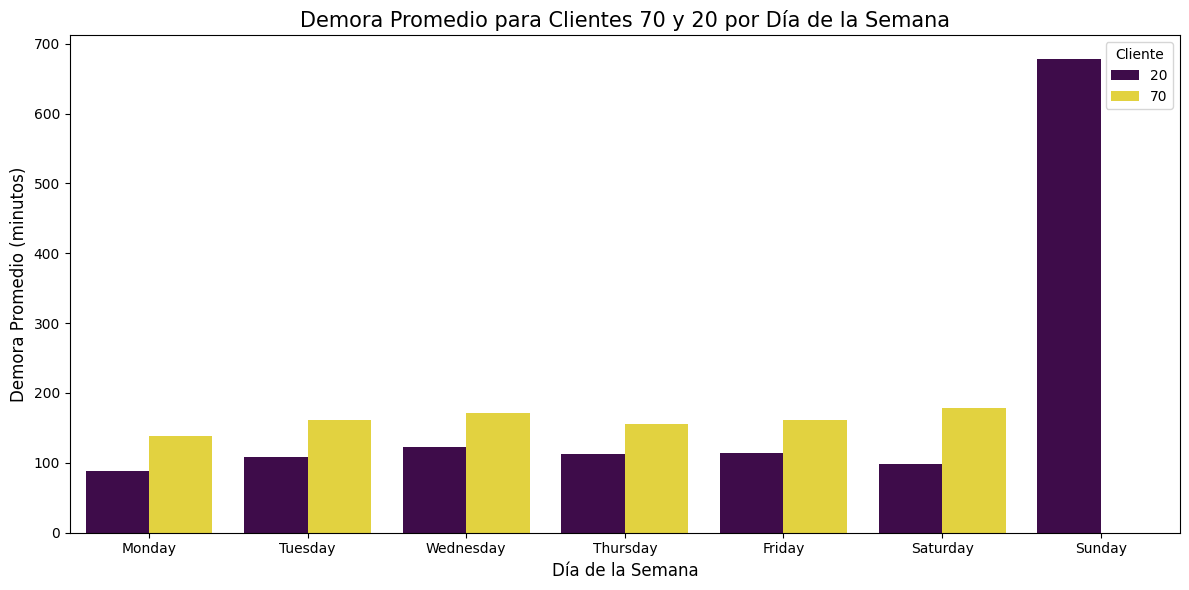

In [23]:

dias_semana_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['VisitaDia'] = pd.Categorical(df['VisitaDia'], categories=dias_semana_orden, ordered=True)

# Filtrar para incluir solo los clientes 70 y 20
df_filtrado = df[df['cliente'].isin([70, 20])]

# Agrupar por 'cliente' y 'VisitaDia' y calcular el promedio de 'Demora'
df_promedio_demora = df_filtrado.groupby(['cliente', 'VisitaDia'])['Demora'].mean().reset_index()

# Manejar valores NaN: reemplazar con 0 o eliminar
df_promedio_demora['Demora'] = df_promedio_demora['Demora'].fillna(0)  # Reemplazar NaN por 0
# o si prefieres eliminar las filas con NaN:
# df_promedio_demora = df_promedio_demora.dropna()

# Convertir 'Demora' a entero para quitar el .0
df_promedio_demora['Demora'] = df_promedio_demora['Demora'].astype(int)

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(x='VisitaDia', y='Demora', hue='cliente', data=df_promedio_demora, palette='viridis')

# Añadir etiquetas y título
plt.xlabel('Día de la Semana', fontsize=12)
plt.ylabel('Demora Promedio (minutos)', fontsize=12)
plt.title('Demora Promedio para Clientes 70 y 20 por Día de la Semana', fontsize=15)

# Mostrar el gráfico
plt.xticks(rotation=0)  # Mantener las etiquetas en horizontal
plt.legend(title='Cliente')
plt.tight_layout()

C:\Users\joela\AppData\Local\Temp\ipykernel_30812\2260092756.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_proporcion_demora = df.groupby('VisitaDia').apply(calcular_proporcion).reset_index(name='Proporcion')
C:\Users\joela\AppData\Local\Temp\ipykernel_30812\2260092756.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_proporcion_demora = df.groupby('VisitaDia').apply(calcular_proporcion).reset_index(name='Proporcion')
C:\Users\joela\AppData\Local\Temp\ipykernel_30812\2260092756.py:16: FutureW

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

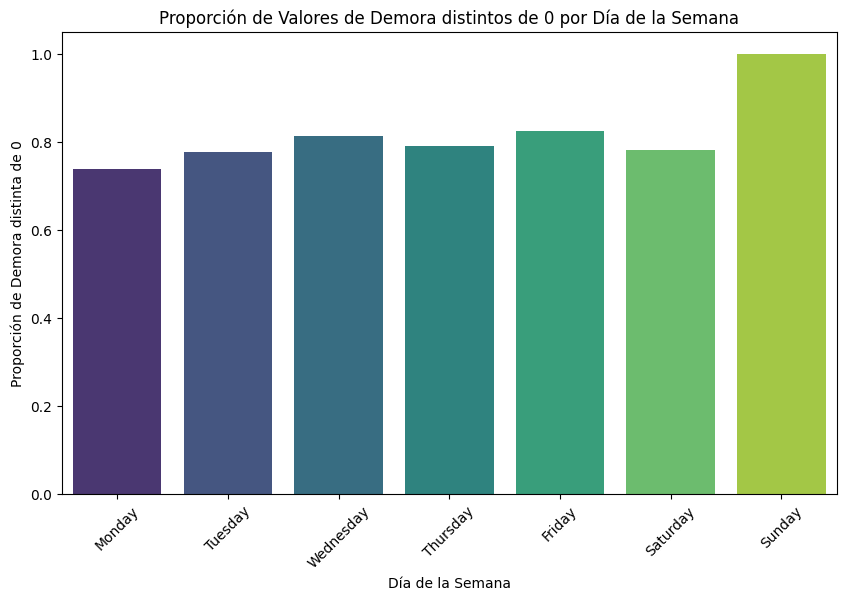

In [44]:
# Suponiendo que ya tienes 'VisitaDia' como una columna categórica con los días de la semana en orden
dias_semana_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['VisitaDia'] = pd.Categorical(df['VisitaDia'], categories=dias_semana_orden, ordered=True)

# Función para calcular la proporción de valores distintos de 0 en 'Demora' por cada día
def calcular_proporcion(df):
    total_registros = df.shape[0]
    valores_distintos_de_cero = df[df['Demora'] != 0].shape[0]
    return valores_distintos_de_cero / total_registros if total_registros > 0 else 0

# Agrupar por día de la semana y calcular la proporción
df_proporcion_demora = df.groupby('VisitaDia').apply(calcular_proporcion).reset_index(name='Proporcion')

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='VisitaDia', y='Proporcion', data=df_proporcion_demora, palette='viridis')

# Añadir etiquetas y título
plt.xlabel('Día de la Semana')
plt.ylabel('Proporción de Demora distinta de 0')
plt.title('Proporción de Valores de Demora distintos de 0 por Día de la Semana')

# Mostrar el gráfico
plt.xticks(rotation=45)

C:\Users\joela\AppData\Local\Temp\ipykernel_30812\1343542672.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_proporcion_anticipado = df.groupby('VisitaDia').apply(calcular_proporcion_anticipado).reset_index(name='Proporcion')
C:\Users\joela\AppData\Local\Temp\ipykernel_30812\1343542672.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_proporcion_anticipado = df.groupby('VisitaDia').apply(calcular_proporcion_anticipado).reset_index(name='Proporcion')
C:\Users\joela\AppData\Local\Temp\ipykernel_3

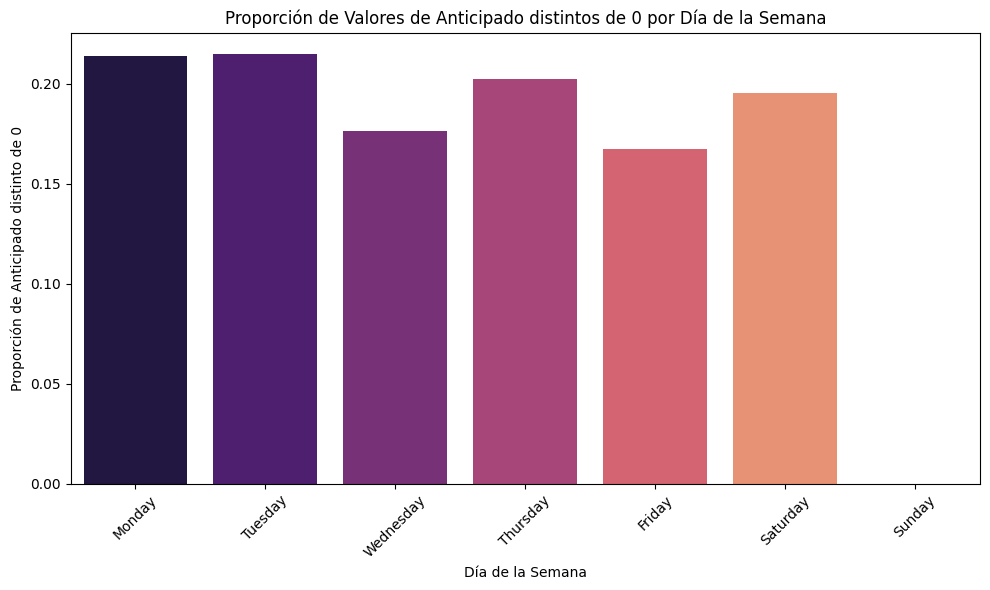

In [46]:
dias_semana_orden = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['VisitaDia'] = pd.Categorical(df['VisitaDia'], categories=dias_semana_orden, ordered=True)

# Función para calcular la proporción de valores distintos de 0 en 'Anticipado' por cada día
def calcular_proporcion_anticipado(df):
    total_registros = df.shape[0]
    valores_distintos_de_cero = df[df['Anticipado'] != 0].shape[0]
    return valores_distintos_de_cero / total_registros if total_registros > 0 else 0

# Agrupar por día de la semana y calcular la proporción
df_proporcion_anticipado = df.groupby('VisitaDia').apply(calcular_proporcion_anticipado).reset_index(name='Proporcion')

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='VisitaDia', y='Proporcion', data=df_proporcion_anticipado, palette='magma')

# Añadir etiquetas y título
plt.xlabel('Día de la Semana')
plt.ylabel('Proporción de Anticipado distinto de 0')
plt.title('Proporción de Valores de Anticipado distintos de 0 por Día de la Semana')

# Mostrar el gráfico
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()